<a href="https://colab.research.google.com/github/victor-armegioiu/Time-Series-Prediction/blob/main/VK_Energie_(_Encoder_Decoder_Luong_Attention_Seasonal_Splitting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum Project (VK Energie - Forecasting Heat Demand)

# Boilerplate 

This section does necesary imports, loads/parses the data.

In [ ]:
# Non-neural based math imports.
import numpy as np

import scipy 
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Data loading
import pandas as pd
import csv

In [ ]:
# Drawing stuff.
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.style.use('ggplot')

In [ ]:
# Neural networks stuff.
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

In [ ]:
df = pd.DataFrame()
reader = csv.reader(
    open("Oberbayern.csv"), delimiter=";")

rows = [row for row in reader]
df = df.append(rows[1:])

In [ ]:
df.columns = ['TimestampUtc', 'Heat Demand', 'Ambient Temperature',  
              'Solar Irradiance']

In [ ]:
for column in df.columns[1:]:
  df[column] = df[column].astype(float)

# Data Analysis

This section covers the following analyses on the dataset:


*   Peaking at samples from the data.
*   Missing values count
*   Overall statistics on the regressors/regressands (mean, max, std, etc). Plots for the histograms.
*   Correlation analysis - Making sure the correlations between the features and the targets make sense, as well as ensuring we don't have too strong a linear correlation between the features. 



In [ ]:
df

,TimestampUtc,Heat Demand,Ambient Temperature,Solar Irradiance
0,2020-02-26 17:00:00+01:00,5715.7325,1.370000,0.050000
1,2020-02-26 18:00:00+01:00,5810.5000,0.880000,0.000000
2,2020-02-26 19:00:00+01:00,6059.9000,0.670000,0.000000
3,2020-02-26 20:00:00+01:00,6114.0850,0.600000,0.000000
4,2020-02-26 21:00:00+01:00,6027.0525,0.540000,0.000000
...,...,...,...,...
5941,2020-11-02 12:00:00+01:00,3431.5000,16.787415,5.718750
5942,2020-11-02 13:00:00+01:00,3221.2500,16.833160,7.406250
5943,2020-11-02 14:00:00+01:00,3153.7500,16.731232,2.312500
5944,2020-11-02 15:00:00+01:00,2795.1250,16.396759,7.906250


In [ ]:
df.isnull().sum()

TimestampUtc           0
Heat Demand            0
Ambient Temperature    0
Solar Irradiance       0
dtype: int64

In [ ]:
df.columns

Index(['TimestampUtc', 'Heat Demand', 'Ambient Temperature',
       'Solar Irradiance'],
      dtype='object')

In [ ]:
# Compute and store pairwise correlations between features and
# targets.
correlations = {}
for col1 in df.columns[1:]:
  for col2 in df.columns[1:]:
    if col1 != col2:
      r2_correlation_coeff = stats.pearsonr(df[col1], df[col2])[0]
      correlations[col1, col2] = r2_correlation_coeff

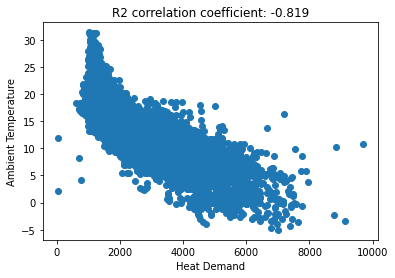

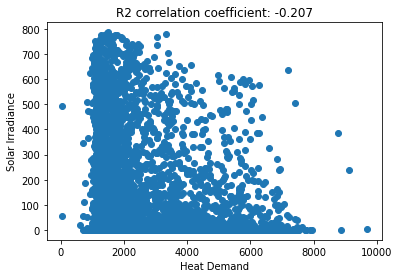

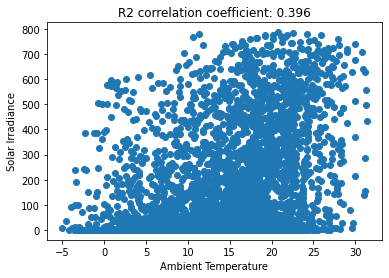

In [ ]:
# Plot all pairwise features/targets/
relevant_columns = df.columns[1:] 

for i in range(len(relevant_columns)):
  for j in range(i + 1, len(relevant_columns)):
    col_i, col_j = relevant_columns[i], relevant_columns[j]
    plt.scatter(df[col_i], df[col_j])
    plt.xlabel(col_i)
    plt.ylabel(col_j)

    r2_correlation_coeff = round(correlations[col_i, col_j], 3)
    plt.title('R2 correlation coefficient: {}'.format(r2_correlation_coeff))
    plt.show()


count    5946.000000
mean     2753.058015
std      1530.114730
min        43.000000
25%      1514.583328
50%      2222.491250
75%      3754.158808
max      9681.533203
Name: Heat Demand, dtype: float64


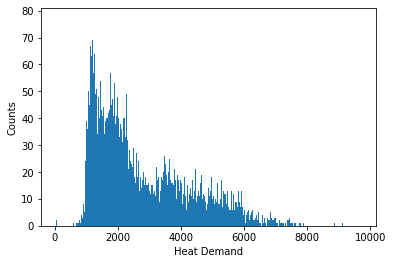


count    5946.000000
mean       13.007976
std         6.339653
min        -5.020000
25%         8.600000
50%        13.198389
75%        17.370000
max        31.371857
Name: Ambient Temperature, dtype: float64


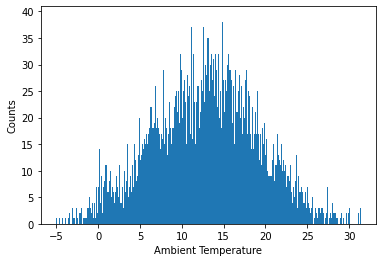


count    5946.000000
mean      105.020707
std       184.026273
min        -0.260000
25%         0.000000
50%         1.812500
75%       131.907500
max       787.470000
Name: Solar Irradiance, dtype: float64


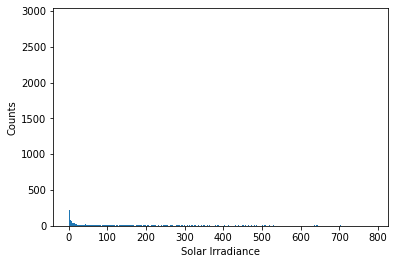

In [ ]:
for column in df.columns[1:]:
  print(df[column].describe())
  plt.hist(df[column], bins=500)
  plt.xlabel(column)
  plt.ylabel('Counts')
  plt.show()
  print()

# Building datasets for training

This section covers the setup needed for creating datasets than can be fed to Pytorch NNs. We also do some preprocessing shift/scale our inputs.

In [ ]:
def DfTrainTestSplitter(df, test_proportion=0.2, as_numpy=True):
  """Split dataframe into train and test data.
  
  In order to have the test distribution as close as possible to th
  train distribution, we split the initial datafram into 4 chunks,
  one corresponding from each season.

  We build the test set by concatenating random samples from each season.
  """
  cnt_test = int(test_proportion * len(df))
  season_cnt = 4
  df_train, df_test = None, None

  for i in range(season_cnt):
    left_idx = i * int(len(df) / season_cnt)
    right_idx = min(int(left_idx + cnt_test // 4.0), len(df) - 2)
    
    if df_test is None:
      df_test = df[left_idx: right_idx + 1]
    else:
      df_test = pd.concat([df_test, df[left_idx: right_idx + 1]])

  df_train = pd.concat([df, df_test]).drop_duplicates(keep=False)
  if as_numpy:
   return df_train.to_numpy()[:, 1:],  df_test.to_numpy()[:, 1:]
  return df_train, df_test

In [ ]:
train_data, test_data = DfTrainTestSplitter(df, test_proportion=0.1)
X_train, y_train = (train_data[:, [1, 2]].astype(float),
                    train_data[:, 0].astype(float))

X_test, y_test = (test_data[:, [1, 2]].astype(float),
                  test_data[:, 0].astype(float))

In [ ]:
X_train.shape, X_test.shape

((5350, 2), (596, 2))

In [ ]:
scaler = MinMaxScaler().fit(X_train)

In [ ]:
# Use the same scaler in order to ensure that we don't inject knowledge
# about the test distribution in our training biases.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

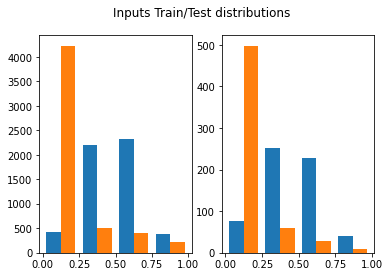

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Inputs Train/Test distributions')
ax1.hist(X_train, bins=4)
ax2.hist(X_test, bins=4)
plt.show()

In [ ]:
# Scale both dataset by `y_train_max`. Same reasoning
# as in using the same scaler on inputs. This is done to avoid
# exploding gradients.
y_train_max = y_train.max()
y_train /= y_train_max
y_test /= y_train_max

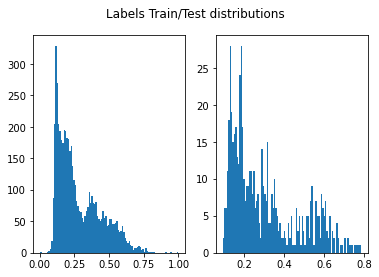

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Labels Train/Test distributions')
ax1.hist(y_train, bins=100)
ax2.hist(y_test, bins=100)
plt.show()

# Batching Logic 

This section defines the necessary utilities for producing batches of variable length sequences.

In [ ]:
def GetInitialBatchIndex(X, input_len, prediction_window_len=48):
  """ 
      Returns a random index from which to sample `input_len` inputs.
      This was written separately so that we can test that it produces an
      even distribution among potential starting indices.
  """
  left_idx = np.random.randint(
      low=0,
      high=max(len(X) - prediction_window_len * 2 - input_len - 1, 1))
  right_idx = left_idx + input_len - 1
  return left_idx

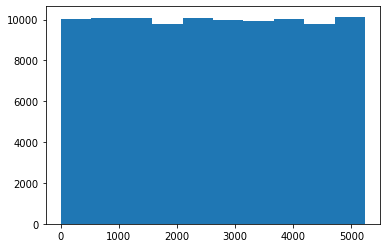

In [ ]:
# Confirm that starting indices for bathches are evenly distributed.
no_trials = 100000
start_indices_samples = []

for _ in range(no_trials):
  start_indices_samples.append(GetInitialBatchIndex(X_train, 15))

plt.hist(start_indices_samples)
plt.show()

In [ ]:
def GetSample(X, y, input_len, prediction_window_len=48, use_noise_reg=False):
  """Return a single input sequence and its respective targets.
  
  Args:
    X: np.array from which to extract input sequences.
    y: np.array from which to extract the regression targets corresponding
       to the selected inputs.
    prediction_window_len: length of the prediction window, which describes
      how many predictions we have to do for a given input sequence.
    use_noise_reg: bool indication whether to inject the labels with noise.

  Return:
    X_tensor: tensorized inputs.
    y_tensor: tensorized targets.

  Note, since we can use forecasts, we also include future data in our
  sequences.
  """
  left_idx = GetInitialBatchIndex(X, input_len, prediction_window_len)
  right_idx = left_idx + input_len - 1

  # Add `prediction_window_len` to our right index, since we can use future
  # values as well, given that we always expect to have forecasts availabel.
  X_tensor = torch.Tensor(X[left_idx : right_idx + 1 + prediction_window_len])
  y_tensor = torch.Tensor(
      y[right_idx + 1 : right_idx + prediction_window_len + 1])

  return X_tensor, InjectGaussianNoise(y_tensor) if use_noise_reg else y_tensor

In [ ]:
def GetBatch(X, y, batch_size, input_len, device, prediction_window_len=48,
             use_noise_reg=False):
  Xs, ys = [], []
  for _ in range(batch_size):
    X_tensor, y_tensor = GetSample(X, y, 
                                   input_len,
                                   prediction_window_len,
                                   use_noise_reg)
    Xs.append(X_tensor)
    ys.append(y_tensor)
  return (torch.stack(Xs).to(device),
          torch.stack(ys).to(device))

# Neural Models Definitions

This section covers defining the classes needed for our regression models:

We shall employ a seq2seq approach, where we unroll a Luong attention based decoder step by step, instead of predicting everything at a time.



In [ ]:
def InjectGaussianNoise(X, isotropic_std=0.1):
  return torch.normal(mean=X, std=isotropic_std)

In [ ]:
class EncoderRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = torch.nn.Linear(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, True, 
                                batch_first=True)
        
    def forward(self, inputs, hidden=None):
        embedded = self.embedding(inputs)
        output, hidden = self.gru(embedded)
        return output, hidden

## Attention Layer

This layer is to be used as part of the decoding architecture.
It basically takes all `encoder_outputs` (denote an output at any given encoder timestep by $h_i\vert_{i=1}^n$), and for every timestep unrolled by the decoder, it computes an attention weight.

Specifically, at decoding step time `t`, the decoder takes its output from its own `GRU` cell, call that $\bar{h}_t$ and computes a set of weights, via dot products $w_i\vert_{i=1}^n = Softmax(\langle \bar{h}_t, h_i \rangle_{W}) = Softmax(\bar{h}_t^T  W h_i$).

In [ ]:
class Attn(torch.nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        self.hidden_size = hidden_size
        self.attn = torch.nn.Linear(self.hidden_size, hidden_size)

    def forward(self, hidden, encoder_outputs, batch_size, seq_len):
        attn_energies = Variable(torch.zeros(batch_size, seq_len, 1))
        for i in range(batch_size):
          attn_energies[i] = self.inner_product(hidden.permute(1, 0, 2)[i],
                                        encoder_outputs[i])
        return F.softmax(attn_energies, dim=1)
    
    def inner_product(self, hidden, encoder_output):
      energies = self.attn(encoder_output)
      return torch.mm(energies, hidden.permute(1, 0))        

In [ ]:
class AttnDecoderRNN(torch.nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.0,
                 device='cpu'):
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Projection matrix for the inputs.
        self.embedding = torch.nn.Linear(output_size, hidden_size)

        # Decoder has its own GRU cell - we unroll one step at a time, 
        # hence producing predictions incrementally for 48 time steps.
        self.gru = torch.nn.GRU(hidden_size * 2, hidden_size, n_layers,
                                dropout=dropout_p, batch_first=True)
        
        # Project the hidden layer to a scalar, i.e. our prediction.
        self.out = torch.nn.Linear(hidden_size * 2, output_size)

        # Luong attention mechanism - At each decoding timestep, we create
        # a learnable convex combination of the encoder's outputs into a 
        # single context layer.
        self.attn = Attn(hidden_size)
        self.device = device
    
    def forward(self, input, last_context, last_hidden, encoder_outputs,
                batch_size, seq_len):    
      # This is just embedding the inputs in slightly higher dimensional spaces.
      input_embedding = self.embedding(input)
      input_embedding = input_embedding[:, None, :]
      rnn_input = torch.cat((input_embedding, last_context),
                            dim=2)

      # This GRU unit decodes all information we've received so far and 
      # produces the output for this timestep - Keep in mind, the decoder
      # is unrolled one timestep at a time.
      output, hidden = self.gru(rnn_input, last_hidden)

      # Compute attention weights per every sequence in the batch.
      # Hence, this produces a tensor of shape [batch_size, seq_len, 1],
      # which shows how much the decoder should 'attend' to any given output
      # of the encoder.
      batch_weights = self.attn(output.permute(1, 0, 2), encoder_outputs,
                                batch_size, seq_len).to(self.device)
                                
      # Compute context vector for this timestep as a weighted sum of 
      # encoder outputs, based on the attention weights.
      context = torch.sum(batch_weights * 
                          encoder_outputs.to(self.device), dim=1)
      context = context[:, None, :]
      output = F.relu(self.out(torch.cat((output, context), dim=2)))
      
      return output, hidden, context


In [ ]:
# Sample usage.
batch_size = 10
X, y = GetBatch(X_train, y_train, batch_size, 12, 'cpu')
print('Input/target shape:', X.shape, y.shape)

net = EncoderRNN(2, 16).to('cpu')
out, hidden = net(X)
print('Batched output shape (all hidden states)/Last hidden state shape:',
      out.shape, hidden.shape)

# Setup decoder - (hidden_size, output_size) = (16, 1)
decoder = AttnDecoderRNN(16, 1)

# Initializing decoder inputs as zeros.
decoder_input = Variable(torch.zeros(batch_size, 1))
decoder_context = Variable(torch.zeros(batch_size, 1, decoder.hidden_size))
decoder_hidden = hidden 

# Unroll a few decoder steps to see how this works.
# The number 60 == sequence_length + 48, here sequence_length == 12.
dec_out, dec_hidden, dec_context = decoder(decoder_input,
                                           decoder_context,
                                           decoder_hidden,
                                           out,
                                           batch_size,
                                           60)

# No teacher forcing - decoder_input == dec_out (previous_output), this uses
# its own previous output as input.
dec_out, dec_hidden, dec_context = decoder(dec_out.squeeze(1),
                                           dec_context,
                                           dec_hidden,
                                           out, batch_size, 60)

# With teacher forcing - this uses what's supposed to be the real targets 
# for the previous step as input to enforce correctness. Note, that the 
# column `1` in y[:, 1, None] is arbitrarily selected here for illustration
# purposes.
dec_out, dec_hidden, dec_context = decoder(y[:, 1, None],
                                           dec_context,
                                           dec_hidden,
                                           out, batch_size, 60)

print(dec_out.shape)

Input/target shape: torch.Size([10, 60, 2]) torch.Size([10, 48])
Batched output shape (all hidden states)/Last hidden state shape: torch.Size([10, 60, 16]) torch.Size([1, 10, 16])
torch.Size([10, 1, 1])


# Training/Testing Setup

This section covers the training procedure, records training metrics, plots train/test loss curves, and shows how to do inference with a trained model.

In [ ]:
def _GetDevice():
  return torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [ ]:
def train(device=_GetDevice(),
          epochs=100,
          batch_size=32,
          prediction_window_len=48,
          input_size=2,
          hidden_size=16,
          output_size=1):

  # Encoder, optimizer instantiations.
  encoder = EncoderRNN(input_size=input_size,
                       hidden_size=hidden_size).to(device)
  enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)

  # Decoder, optimizer instantiations.
  decoder = AttnDecoderRNN(hidden_size=hidden_size,
                           output_size=output_size,
                          device=device).to(device)
  dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)

  # Regression loss.
  mse_loss = torch.nn.MSELoss() 

  iterations_per_epoch = len(df) // batch_size
  train_losses, val_losses = [], []
  print(epochs, iterations_per_epoch)

  for epoch in range(epochs):
    for iter in range(iterations_per_epoch):
      enc_optimizer.zero_grad()
      dec_optimizer.zero_grad()

      # Sample varying sequence lengths to use for prediction.
      input_len = np.random.randint(low=5, high=10)
      inputs, targets = GetBatch(X_train, y_train,
                                batch_size,
                                input_len,
                                device,
                                prediction_window_len,
                                False)
      
      # Use teacher forcing in 50% of the time. If this is `True`, the decoder
      # will use the correct label for timestep `t` as an input for timestep
      # `t + 1`. Otherwise, the decoder will use its previous output from 
      # time `t` as input for time `t + 1`. This strikes a good balance since
      # the model is forced to produce sensbile outputs, while it
      # also learns to extrapolate and generalize from its own predictions.
      use_teacher_forcing = np.random.random() >= 0.7
      encoder_outputs, encoder_last_hidden = encoder(inputs)

      # Prepare initial inputs of the decoder - the previous input and context
      # are randomly initialized, but the previous hidden state will be
      # initialized as the last hidden state of the encoder.
      decoder_input = Variable(torch.randn(batch_size, 1)).to(device)
      decoder_context = Variable(torch.zeros(batch_size, 1,
                                            decoder.hidden_size)).to(device)
      decoder_hidden = encoder_last_hidden.to(device)

      # Start decoding, one step at a time.
      dec_out, dec_hidden, dec_context = decoder(decoder_input,
                                                decoder_context,
                                                decoder_hidden,
                                                encoder_outputs,
                                                batch_size,
                                                input_len + 48)
      
      predictions = [dec_out.squeeze(1)]
      for timestep in range(1, prediction_window_len):
        if use_teacher_forcing:
          # As mentioned before, if teacher forcing is enable, we use the
          # right label from the previous timestep as input for the current one.
          decoder_input = targets[:, timestep - 1, None]
        else:
          decoder_input = dec_out.squeeze(1)
        dec_out, dec_hidden, dec_context = decoder(decoder_input,
                                                  dec_context,
                                                  dec_hidden, 
                                                  encoder_outputs,
                                                  batch_size,
                                                  input_len + 48)
        predictions.append(dec_out.squeeze(1))
      predictions = torch.stack(predictions).permute(1, 0, 2).squeeze(-1)
      
      # Compute and record MSE loss.
      train_loss = mse_loss(predictions, targets)
      train_losses.append(train_loss)

      # Backprop and update parameters.
      train_loss.backward()
      enc_optimizer.step()
      dec_optimizer.step()
      
      with torch.no_grad():
        input, targets = GetBatch(X_test, y_test, batch_size, input_len, device)
        predictions = [dec_out.squeeze(1)]
        for _ in range(prediction_window_len - 1):
          dec_out, dec_hidden, dec_context = decoder(dec_out.squeeze(1),
                                                    dec_context,
                                                    dec_hidden, 
                                                    encoder_outputs,
                                                    batch_size,
                                                    input_len + 48)
          predictions.append(dec_out.squeeze(1))
        predictions = torch.stack(predictions).permute(1, 0, 2).squeeze(-1)
        mae_loss = torch.nn.L1Loss()(predictions, targets) * y_train_max
        print('MAE:', mae_loss)

        val_loss = mse_loss(predictions, targets)
        val_losses.append(val_loss)
        print(val_loss.item())    

      if epoch % 10 == 0 and iter == iterations_per_epoch % 5 == 0:
        print('Epoch:', epoch)
        print('Train loss:', train_loss.item())
        print('Val loss:', val_loss.item())
        print('\n')
  return encoder, decoder, train_losses, val_losses

In [ ]:
# Customize this loop however you prefer.
encoder, decoder, train_losses, val_losses = train()

100 185
MAE: tensor(2774.0405, device='cuda:0')
0.11578216403722763
Epoch: 0
Train loss: 0.08659429848194122
Val loss: 0.11578216403722763


MAE: tensor(1622.6304, device='cuda:0')
0.042873919010162354
MAE: tensor(1491.3876, device='cuda:0')
0.04289187118411064
MAE: tensor(1408.2216, device='cuda:0')
0.040525101125240326
MAE: tensor(1493.6637, device='cuda:0')
0.04269148409366608
MAE: tensor(1133.0305, device='cuda:0')
0.024713076651096344
MAE: tensor(1323.7289, device='cuda:0')
0.028534989804029465
MAE: tensor(1332.6292, device='cuda:0')
0.027570005506277084
MAE: tensor(1413.2712, device='cuda:0')
0.027279308065772057
MAE: tensor(1406.7767, device='cuda:0')
0.027557937428355217
MAE: tensor(1683.4091, device='cuda:0')
0.03669007867574692
MAE: tensor(1784.7566, device='cuda:0')
0.040667902678251266
MAE: tensor(1588.3551, device='cuda:0')
0.033579252660274506
MAE: tensor(1692.3167, device='cuda:0')
0.03790049999952316
MAE: tensor(1605.6313, device='cuda:0')
0.034602031111717224
MAE: tens

KeyboardInterrupt: ignored

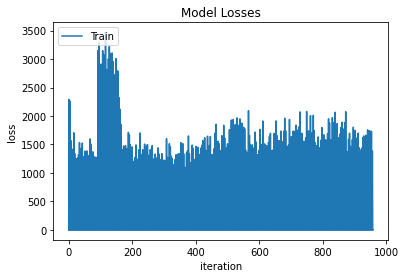

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)

plt.title('Model Losses')
plt.legend(['Train', 'Val'], loc='upper left')

plt.ylabel('loss')
plt.xlabel('iteration')

plt.show()